In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import os
import sys
from pprint import pprint
from pylab import rcParams

In [2]:
sys.path.append("../")
import core.tools.json_rec as json_rec

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

In [4]:
import tools
from typing import List, Tuple

In [5]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

### CONTROL PANEL

In [6]:
PATH_COL = tools.mkdirs(f"./saved/{now}")
pprint(PATH_COL)
PARAMS = dict(
    COL_NAME = "UNRATE",
    P = 6,
    NUM_TIME_STEPS = 6,
    D = 1,
    Q = None,
    NUM_INPUTS = 1,
    NUM_OUTPUTS = 1,
    # Training Config
    RNN_NEURONS = [128, 256, 256],
    LR = 0.01,
    EPOCHS = 1000,
    CELL_TYPE = "LSTM",
)

Creating directory: ./saved/2019-01-07_02:09:57
Creating directory: ./saved/2019-01-07_02:09:57/tensorboard
Creating directory: ./saved/2019-01-07_02:09:57/figures
Creating directory: ./saved/2019-01-07_02:09:57/numericals
{'BASE_PATH': './saved/2019-01-07_02:09:57',
 'FIG_PATH': './saved/2019-01-07_02:09:57/figures',
 'NUM_PATH': './saved/2019-01-07_02:09:57/numericals',
 'TB_PATH': './saved/2019-01-07_02:09:57/tensorboard'}


In [7]:
globals().update(PATH_COL)
globals().update(PARAMS)

In [8]:
param_writer = json_rec.ParamWriter()
param_writer.write(PARAMS, file_dir=PATH_COL["BASE_PATH"] + "/params.json")
param_writer.write(PATH_COL, file_dir=PATH_COL["BASE_PATH"] + "/paths.json")

In [9]:
df = pd.read_csv("./data/UNRATE.csv", index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = [COL_NAME]
print(df.dtypes)
df.head()
# month_df = df.resample("M").mean().head()

UNRATE    float64
dtype: object


,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [10]:
diff = df.diff()  #  Take the first order differenced.
diff.dropna(inplace=True)
slp = tools.gen_slp_sequential(diff, num_time_steps=P)

Failed time step ignored: 845
Failed time step ignored: 846
Failed time step ignored: 847
Failed time step ignored: 848
Failed time step ignored: 849
Failed time step ignored: 850


In [11]:
X, y, ts = tools.format_instances(slp)

num_instances=845, num_inputs=1, num_outputs=1, num_time_steps=6


In [12]:
(X_train, y_train, ts_train,
X_val, y_val, ts_val,
X_test, y_test, ts_test) = tools.split_dataset(X, y, ts)

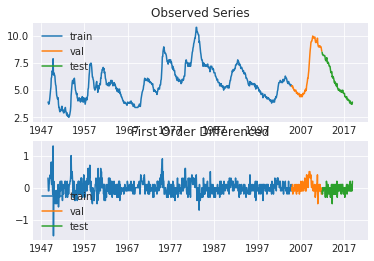

In [13]:
ax1 = plt.subplot(2, 1, 1)
rcParams["figure.figsize"] = (32, 16)
plt.title("Observed Series")
plt.plot(ts_train, df[COL_NAME][ts_train], label="train")
plt.plot(ts_val, df[COL_NAME][ts_val], label="val")
plt.plot(ts_test, df[COL_NAME][ts_test], label="test")
plt.legend()
plt.grid(True)

ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("First Order Differenced")
plt.plot(ts_train, y_train[:, -1, :], label="train")
plt.plot(ts_val, y_val[:, -1, :], label="val")
plt.plot(ts_test, y_test[:, -1, :], label="test")
plt.legend()
plt.grid(True)

plt.savefig(PATH_COL["FIG_PATH"] + "/raw.png", dpi=300)
plt.show()

In [14]:
# ax = plt.figure(figsize=(32,8))
# plt.title("Log")
# plt.plot(ts_train, np.log(y_train[:, -1, :]), label="train")
# plt.plot(ts_val, np.log((y_val[:, -1, :])), label="val")
# plt.plot(ts_test, np.log(y_test[:, -1, :]), label="test")
# plt.legend()
# plt.grid(True)
# plt.show()

In [15]:
tf.reset_default_graph()
# Build LSTM Neural Net
# Data IO Layers
with tf.name_scope("DATA_IO"):
    X = tf.placeholder(
        tf.float32,
        [None, NUM_TIME_STEPS, NUM_INPUTS],
        name="FEATURE"
    )
    y = tf.placeholder(
        tf.float32,
        [None, NUM_TIME_STEPS, NUM_OUTPUTS],
        name="LABEL"
    )

In [16]:
# Recurrent Structure.
# with tf.name_scope("RECURRENT"):
if CELL_TYPE == "GRU":
    cells = [
        tf.nn.rnn_cell.GRUCell(
            num_units=x,
            name=f"GRU_LAYER_{i}")
        for i, x in enumerate(RNN_NEURONS)
    ]
elif CELL_TYPE == "LSTM":
    cells = [
        tf.nn.rnn_cell.LSTMCell(
            num_units=x,
            name=f"LSTM_LAYER_{i}")
        for i, x in enumerate(RNN_NEURONS)
    ]
else:
    cells = [
        Cell(
            num_units=x,
            name=f"RNN_LAYER_{i}")
        for i, (Cell, x) in enumerate(zip(CellType, x))
    ]

multi_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
outputs, state = tf.nn.dynamic_rnn(
    cell=multi_cell,
    inputs=X,
    dtype=tf.float32
)

In [17]:
# with tf.name_scope("OUTPUT"):
reg_outputs = tf.layers.dense(
    outputs,
    NUM_OUTPUTS,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=None,  # linear activation.
    name="OUTPUT_DENSE"
)
# W = tf.Variable(
#     tf.random_normal(
#     [RNN_NEURONS[-1], NUM_OUTPUTS],
#     name="OUTPUT_WEIGHT"
#     )
# )
# b = tf.Variable(
#     tf.random_normal(
#     [NUM_OUTPUTS, 1],
#     name="OUTPUT_BIAS"
#     )
# )
# reg_outputs = outputs @ W + b

In [18]:
with tf.name_scope("METRICS"):
#     loss = tf.losses.mean_squared_error(
#         labels=y,
#         predictions=reg_outputs,
#     )
    
    # Redundent losses to evaluate and ensure the correctness of
    # built-in losses function.
    loss = tf.reduce_mean(
        tf.square(y - reg_outputs),
        name="Red_MSE",
        axis=None
    )
    tf.summary.scalar("MSE", loss)
#     tf.summary.scalar("Red_MSE", loss2)

In [19]:
with tf.name_scope("OPTIMIZER"):
    optimizer = tf.train.AdamOptimizer(
        learning_rate=LR,
        name="OPTIMIZER"
    )
#     gvs = optimizer.compute_gradients(loss)
#     capped_gvs = [
#         (tf.clip_by_value(
#             grad, -1.0, 1.0), var)
#         for grad, var in gvs
#     ]
#     train = optimizer.apply_gradients(capped_gvs)
    train = optimizer.minimize(loss)

In [ ]:
start = datetime.datetime.now()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    merged_summary = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(TB_PATH + "/train")
    val_writer = tf.summary.FileWriter(TB_PATH + "/validation")
    train_writer.add_graph(sess.graph)
    for e in range(EPOCHS):
#         tools.progbar(e+1, EPOCHS, 30)
        sess.run(
            train,
            feed_dict={X: X_train, y: y_train}
        )
        if e % (EPOCHS // 10) == 0:
            train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
            val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
            print(f"Epoch={e}: train_MSE={train_mse}, val_MSE={val_mse}")
    
        if e % 5 == 0:
            tsum = sess.run(
                merged_summary,
                feed_dict={X: X_train, y: y_train}
            )
            vsum = sess.run(
                merged_summary,
                feed_dict={X: X_val, y: y_val}
            )
            train_writer.add_summary(tsum, e)
            val_writer.add_summary(vsum, e)
            
    make_prediction = lambda data: sess.run(reg_outputs, feed_dict={X: data})
    pred_train = make_prediction(X_train)
    pred_val = make_prediction(X_val)
    pred_test = make_prediction(X_test)
print(f"Time taken: {datetime.datetime.now() - start}")

Epoch=0: train_MSE=0.9910910129547119, val_MSE=0.7607473731040955
Epoch=100: train_MSE=0.04315418004989624, val_MSE=0.02809523046016693
Epoch=200: train_MSE=0.04283649101853371, val_MSE=0.02822236157953739
Epoch=300: train_MSE=0.04264766722917557, val_MSE=0.028244297951459885
Epoch=400: train_MSE=0.04239261895418167, val_MSE=0.02815547026693821
Epoch=500: train_MSE=0.041660126298666, val_MSE=0.0278520155698061
Epoch=600: train_MSE=0.03965363651514053, val_MSE=0.02683090791106224
Epoch=700: train_MSE=0.03831515461206436, val_MSE=0.025852356106042862
Epoch=800: train_MSE=0.0371411107480526, val_MSE=0.025149408727884293


In [ ]:
extract_last = lambda pred_combo: np.squeeze([x[-1] for x in pred_combo])
# NOTE: dfp stands for DataFrame of Prediction
dfp_train = pd.DataFrame(data=extract_last(pred_train), index=ts_train)
dfp_val = pd.DataFrame(data=extract_last(pred_val), index=ts_val)
dfp_test = pd.DataFrame(data=extract_last(pred_test), index=ts_test)

In [ ]:
pred_diff = pd.concat([dfp_train, dfp_val, dfp_test])
pred_diff.columns = [COL_NAME]

In [ ]:
pred_raw = tools.inv_diff(pred_diff, df)

In [ ]:
# ==== Raw ====
ax1 = plt.subplot(2, 1, 1)
rcParams["figure.figsize"] = (16, 8)
plt.title("Ground truth versus Prediction on Raw Series")
plt.plot(df, label="Observed", alpha=.6)
plt.plot(pred_raw, label="Prediction", alpha=.6)

plt.axvline(x=diff.index[len(X_train)+1], color="grey", alpha=.4, label="train-val boundary")
plt.axvline(x=diff.index[-len(X_test)+1], color="grey", alpha=.4, label="val-test boundary")
plt.grid(True)

ax1.set_xlabel("Date")
ax1.set_ylabel("UNRATE")
plt.legend()

# ==== First order differenced ====
ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (16, 8)
plt.title("Ground truth versus Prediction on First Order Differenced")
plt.plot(diff, label="Observed(Ground Truth)", color="grey", alpha=.7)
plt.plot(dfp_train, label="Train", alpha=.7)
plt.plot(dfp_val, label="Validation", alpha=.7)
plt.plot(dfp_test, label="Test", alpha=.7)
plt.legend()

ax2.set_xlabel("Date")
ax2.set_ylabel("Change in UNRATE")
plt.grid(True)

plt.savefig(PATH_COL["FIG_PATH"] + "/prediction.png", dpi=300)
plt.show()